# <span style="color:red">6. Assignment
</span>

## Portfolio Management
### MLP Training

#### January 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Timing

### 1.1. 

Use the data found in `mkt_timing_data.xlsx`.

Construct an investment strategy where you go long `SPY` (100%) at any time where the earnings-price ratio (E/P) is above `4.5%`. When the ratio is below this level, you are long Tbills (100%) and earning `US3M`.

Report the following statsitics in a table where the first column is `SPY` and the second column is your strategy,
* mean
* vol
* Sharpe

Also report the correlation between your strategy and `SPY`.

In [225]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

unnamed = 'Unnamed: 0'
path = '../data/mkt_timing_data.xlsx'
sigs = pd.read_excel(path, 'signals').set_index(unnamed)
sigs.index = sigs.index.rename('date')

spy_ret = pd.read_excel(path, 'returns (total)').set_index(unnamed)
spy_ret.index = spy_ret.index.rename('date')

tbill_ret = pd.read_excel(path, 'risk-free rate').set_index(unnamed)
tbill_ret.index = tbill_ret.index.rename('date')

display(sigs)
display(spy_ret.head())
display(tbill_ret.head())

,DP,EP,US10Y
date,,,
1993-02-28,2.82,4.44,6.03
1993-03-31,2.77,4.41,6.03
1993-04-30,2.82,4.44,6.05
1993-05-31,2.81,4.38,6.16
1993-06-30,2.79,4.31,5.80
...,...,...,...
2023-06-30,1.58,3.88,3.81
2023-07-31,1.53,3.76,3.97
2023-08-31,1.55,3.89,4.09


,SPY
date,
1993-02-28,0.010667
1993-03-31,0.022408
1993-04-30,-0.025589
1993-05-31,0.026970
1993-06-30,0.003667


,US3M
date,
1993-02-28,0.002508
1993-03-31,0.002458
1993-04-30,0.002475
1993-05-31,0.002608
1993-06-30,0.002583


In [226]:
sigs_lag = sigs.shift().dropna()
spy, tbill = spy_ret[['SPY']].align(tbill_ret[['US3M']], join='inner', axis=0)
sigs_lag, spy = sigs_lag.align(spy[['SPY']], join='inner', axis=0)
sigs_lag, tbill = sigs_lag.align(tbill[['US3M']], join='inner', axis=0)


In [227]:

strat_ret = spy.copy().rename(columns={'SPY':'Strategy Return'})
long_spy_sig_lag = sigs_lag['EP'] > 4.5
long_tbill_sig_lag = ~long_spy_sig_lag

strat_ret[long_spy_sig_lag] = 1.0 * spy[long_spy_sig_lag]
strat_ret[long_tbill_sig_lag] = 1.0 * tbill[long_tbill_sig_lag]


In [228]:
strat_ret

,Strategy Return
date,
1993-03-31,0.002458
1993-04-30,0.002475
1993-05-31,0.002608
1993-06-30,0.002583
1993-07-31,0.002583
...,...
2023-06-30,0.004525
2023-07-31,0.004625
2023-08-31,0.004633


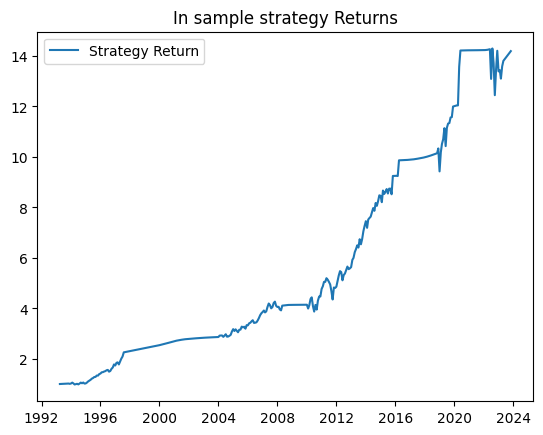

In [229]:
import matplotlib.pyplot as plt

plt.plot((1 + strat_ret).cumprod())
plt.legend(strat_ret.columns)
plt.title('In sample strategy Returns')
plt.show()

### 1.2.

Re-do the previous problem, but instead of setting the weights to 100% and 0%, set the weights to be...

$$w_t = -0.8 + 30x_t$$

In [244]:
(-0.8 + 30 * sigs_lag[['EP']]) * tbill.rename(columns={'US3M':'EP'}) 

,EP
date,
1993-03-31,0.325483
1993-04-30,0.325463
1993-05-31,0.345343
1993-06-30,0.337383
1993-07-31,0.331958
...,...
2023-06-30,0.557028
2023-07-31,0.534650
2023-08-31,0.518933


In [246]:
spy.rename({'SPY':'EP'})

,SPY
date,
1993-03-31,0.022408
1993-04-30,-0.025589
1993-05-31,0.026970
1993-06-30,0.003667
1993-07-31,-0.004855
...,...
2023-06-30,0.064814
2023-07-31,0.032733
2023-08-31,-0.016252


In [250]:
new_strat_ret = spy.copy().rename(columns={'SPY':'Strategy Return'})
long_spy_sig_lag = sigs_lag['EP'] > 4.5
long_tbill_sig_lag = ~long_spy_sig_lag


new_strat_ret = (-0.8 + 30 * sigs_lag[['EP']]) / 100 * spy.rename(columns={'SPY':'EP'}) + (-0.8 + 30 * sigs_lag[['EP']]) / 100 * tbill.rename(columns={'US3M':'EP'}) 

In [251]:
new_strat_ret

,EP
date,
1993-03-31,0.032923
1993-04-30,-0.030395
1993-05-31,0.039161
1993-06-30,0.008163
1993-07-31,-0.002920
...,...
2023-06-30,0.085357
2023-07-31,0.043186
2023-08-31,-0.013013


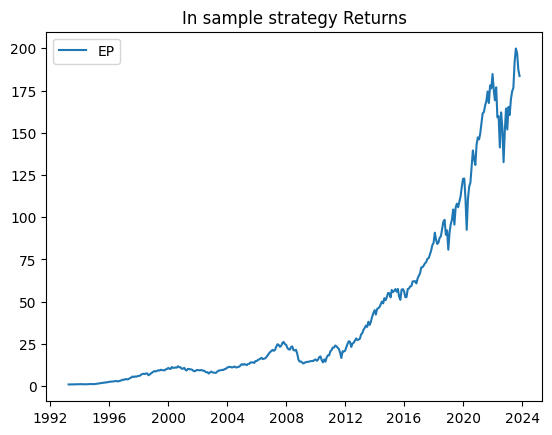

In [252]:
import matplotlib.pyplot as plt

plt.plot((1 + new_strat_ret).cumprod())
plt.legend(new_strat_ret.columns)
plt.title('In sample strategy Returns')
plt.show()

### 1.3.

Run a regression to understand the relationship between `E/P` at time $t$ and the subsequent return in `SPY`. That is, estimate $\beta$ in 

$$r_{SPY,t+1} = \alpha + \beta x_t + \epsilon_{t+1}$$

where $x$ is the E/P ratio.

Report the estimated $\beta$ and r-squared. What do you conclude about the statistical relationship?

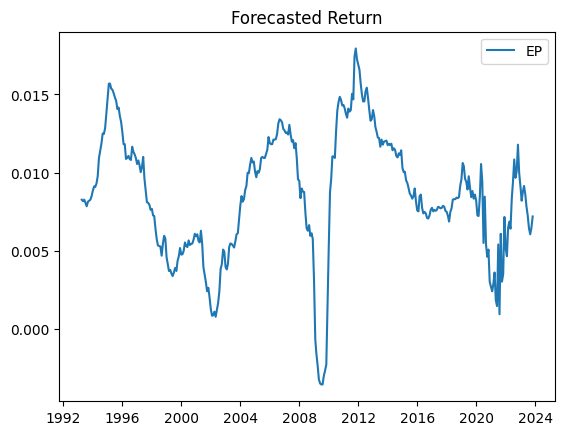

In [253]:
import matplotlib.pyplot as plt

y = spy
X = sigs_lag[['EP']]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
forecast = model.predict(X)
forecast.dropna()

plt.plot(forecast)
plt.legend(["EP"])
plt.title('Forecasted Return')
plt.show()   

In [255]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.209
Date:                Fri, 17 Jan 2025   Prob (F-statistic):             0.0741
Time:                        14:31:20   Log-Likelihood:                 637.14
No. Observations:                 368   AIC:                            -1270.
Df Residuals:                     366   BIC:                            -1262.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0062      0.009     -0.722      0.4

Again we expect a very low R-squared and we get that at 0.009. Our beta is 0.0033.

***